# mdxplain Tutorial: Introduction to Conformational Analysis with mdxplain

## Introduction

Proteins are dynamic molecules that sample multiple conformational states during their lifespan. Understanding which conformations exist and what distinguishes them at the molecular level is crucial for comprehending protein mechanisms.
The challenge in analyzing molecular dynamics (MD) trajectories lies in extracting biologically meaningful conformational states from thousands of simulation frames. Traditional approaches often require manual selection of collective variables or a priori knowledge of relevant structural features.

This tutorial demonstrates mdxplain an automated pipeline builder that can be used to identify distinct conformational states and determines the specific residue-residue contacts that characterize each state. The approach combines machine learning techniques with structural biology principles to transform high-dimensional trajectory data into interpretable biological insights.

### Methodology Overview

The pipeline addresses key challenges in conformational analysis:

1. **Feature Engineering**: Convert atomic coordinates to rotation/translation-invariant contact descriptors
2. **Dimensionality Reduction**: Overcome the curse of dimensionality for clustering in high-dimensional spaces
3. **State Identification**: Determine the number and boundaries of conformational states
4. **State Characterization**: Identify which molecular interactions distinguish each state

### Test System

We analyze the Villin headpiece (PDB: 2RJY [1]), a 64-residue protein domain that serves often as a model system for protein folding studies [2-7]. The trajectory contains 9,368 frames (9368 ns) with 1,027 atoms.

The complete analysis requires 14 lines of code.

# Import

We just need to import one thing. Just the PipelineManager. The whole analysis can be managed from here. We do not need other stuff.

## Design note

Pipeline Builder Module
- We use a builder pattern: the PipelineManager incrementally constructs an internal PipelineData structure.

- Everything is centralized in `pipeline.data` and is enriched by the modules (trajectory, feature, feature_selector, decomposition, clustering, data_selector, comparison, feature_importance).

Analysis module
- The `analysis` module reads from `pipeline.data`.
- It supports statistical analyses on features and structural analyses on trajectories such as RMSD and RMSF.

In [1]:
from mdxplain import PipelineManager

## Methods

### Step 1: Data Loading and Preprocessing

Efficient data handling is essential for processing large MD trajectories. Memory mapping allows analysis of datasets larger than available RAM by loading only required data sections. Residue labeling provides metadata necessary for interpreting structural features.

Note on memory mapping (memmap) and chunk sizing
- What memmap is: Arrays are kept on disk and only the required slices are loaded into RAM on demand. This keeps the memory footprint low at the cost of extra I/O.
- When to enable memmap (use_memmap=True):
  - Trajectories that approach/exceed available RAM
  - Multiple trajectories opened at once
  - Interactive analysis on laptops/workstations with limited memory
- When to disable memmap (use_memmap=False):
  - Small/medium datasets that comfortably fit in RAM
  - You need maximum speed and have ample memory (e.g., HPC node)
  - You are on a slow or remote filesystem where frequent random I/O is costly
- Choosing chunk_size (number of frames processed per batch):
  - Start with 500–2000 as a general rule of thumb; 1000 is a balanced default
  - Increase if you have plenty of RAM (fewer I/O operations, faster overall)
  - Decrease if you observe high memory usage, swapping, or OOM errors

Quick mental model for memory needs
- Per-batch memory = (n_features × bytes_per_feature) × chunk_size_frames + overhead
- Examples: contacts often use 1 byte/feature; float32 distances use 4 bytes/feature
- Aim for the batch to stay well below ~50% of available RAM to leave room for temporary arrays and the OS


In [2]:
# Initialize pipeline and load trajectory data
pipeline = PipelineManager(use_memmap=True, chunk_size=1000)
pipeline.trajectory.load_trajectories(data_input="../data/2RJY/")
pipeline.trajectory.add_labels(traj_selection="all")

📁 Using existing cache: ./cache/simulation_run1.dask.zarr

Loaded 1 systems with 1 total trajectories:
  2RJY: 1 trajectories


### Step 2: Feature Computation

Raw atomic coordinates are sensitive to molecular rotation and translation, making direct comparison between frames problematic. Pairwise residue distances and contacts provide rotation/translation-invariant descriptors that capture the essential physics of protein structure. 

The distances default is a residue-residue metric. So all atom-atom distance between 2 residues are calculated and the closest heavy atom distance (without Hydrogen) is taken.

The contacts used here in the "contacts" feature is a static boolean value. So if the residue-residue distance is lower the threshold, the contact-value is true, else it is false. It is kind of a representation, if two residues interact with each other or not.

The 4.5 Å cutoff encompasses typical ranges for non-bonded interactions. It is a classical default, which is for example also used in mdciao or MDAnalysis.

In [3]:
# TODO: Reference
# Compute distance and contact features
pipeline.feature.add.distances()
pipeline.feature.add.contacts(cutoff=4.5)

Computing distances:   0%|          | 0/1 [00:00<?, ?trajectories/s]

Generated 1953 residue pairs for 64 residues


Processing traj <DaskMDTrajectory with 9368 frames, 1027 atoms, 64 residues, and PBC (openmm format)>: 100%|██████████| 10/10 [00:08<00:00,  1.12chunks/s]
Computing contacts: 100%|██████████| 1/1 [00:00<00:00, 53.74trajectories/s]


### Step 3: Feature Selection

Why focus on contacts here
- Interaction patterns can often reveal mechanistic differences between conformations more clearly than the magnitude of distance changes alone.
- Contacts directly report formation/breaking of specific interactions, mapping naturally to hypotheses, mutational tests, and functional interpretation.
- Therefore, in this tutorial we prioritize a contact-based analysis to highlight how interaction networks change across states.

In [4]:
# Create feature selector focused on contact analysis
# We create a selector and select the contacts of all available atoms / residues in this case
# After this step, we call select to create the feature-matrix in our pipeline
pipeline.feature_selector.create("contacts_only")
pipeline.feature_selector.add.contacts("contacts_only", "all")
pipeline.feature_selector.select("contacts_only")

Created feature selector: 'contacts_only'
Added to selector 'contacts_only': contacts -> 'all' (use_reduced=False, common_denominator=True, traj_selection=all, require_all_partners=False)
Applied feature selector 'contacts_only' with reference trajectory 0 successfully


### Step 4: Dimensionality Reduction

The contact matrix contains (N² - N)/2 features (one per residue pair), creating a high-dimensional space where conventional clustering algorithms fail due to the "curse of dimensionality." 
In high dimensions, all points become approximately equidistant, and noise dominates meaningful signals. Therefore we need to reduce the number of dimensions using a dimension reduction method.

A classical way doing this is a PCA, which tries to neglect correlative information, i.e. redundancy and catch the axis with the most variant linear combinations of features.
Cause MD data are often non-linear, a kernel PCA is the logical update to catch non-linear combinations of features.

Cause we are doing a contact analysis, it could make sense to build a principle component space based directly on this data. Therefore we are doing a contact kernel PCA.

This is basically a RBF kernel on the contact maps. This is equivalent to a hamming distance kernel. So we count the number of differences. 

So the first component holds the non-linear dynamic motion with the biggest change in the interaction pattern of the protein, the second the 2nd biggest and so on, which is a good space to cluster conformational states.

In [5]:
# TODO: Reference
# Apply Contact Kernel PCA
pipeline.decomposition.add.contact_kernel_pca(
    n_components=4, 
    gamma=1e-2, 
    selection_name="contacts_only", 
    decomposition_name="ContactKernelPCA",
    force=True,
)

Centering kernel matrix: 100%|██████████| 10/10 [00:00<00:00, 24.01chunks/s]


Starting eigendecomposition for 4 components...
  Matrix-vector products: 10
  Matrix-vector products: 20
Eigendecomposition completed after 21 matrix-vector products
Decomposition 'contact_kernel_pca' with name 'ContactKernelPCA' for selection 'contacts_only' computed successfully. Data reduced from (9368, 1953) to (9368, 4).


### Step 5: Conformational State Identification

The goal of this step is to group the simulation trajectory data into a set of distinct conformational states using a clustering algorithm.

A primary challenge in this analysis is that conventional clustering methods, such as k-means, are problematic for this type of data. Such methods presuppose spherical cluster shapes and require the number of clusters to be known. Neither assumption is appropriate for the complex and unknown nature of conformational landscapes.

To address these limitations, we employ a density based clustering in this example the Density Peak Advanced (DPA) algorithm. DPA identifies cluster centers as high-density regions that are separated by low-density boundaries, which allows it to automatically determine the optimal number of states. A Z-score(Z-value) threshold of 2.0 is used to achieve a balance between the sensitivity needed to resolve distinct conformational biases and the robustness required to filter out the thermal noise inherent to molecular dynamics simulations.

In our daily analysis of MD data, we find that DPA is not only highly effective but also more straightforward to apply than other density-based methods, such as DBSCAN or HDBSCAN. Its primary advantage lies in its practical approach to hyperparameter tuning. While the DPA algorithm includes several configurable parameters, we have found that in practice, default values are typically sufficient for the clustering of conformational states. The Z-value can the be used to control the desired level of clustering granularity. Higher Z-values produce a coarser clustering with fewer, more distinct states, while lower values yield a more fine-grained result. This provides us with an intuitive mechanism to adjust the clustering resolution, circumventing the need to optimize the more abstract hyperparameters, such as eps and min_samples, required by (H)DBSCAN.

In [6]:
# TODO: Reference
# DPA clustering on decomposed data
pipeline.clustering.add.dpa(
    "ContactKernelPCA", 
    Z=2,
    cluster_name="DPA_ContactKPC",
    #override_cache=True,
    force=True
)

Clustering 'DPA_ContactKPC' completed successfully.
Found 6 clusters for 9368 frames.


### **Step 6: Free Energy Landscape Visualization with Cluster Analysis**

This visualization combines **contact-based kernel PCA** decomposition with **density peak clustering**
to reveal the conformational landscape of the molecular dynamics trajectory.

#### Plot Features

**Energy Landscape Background:**
- Calculated via Gaussian kernel density estimation (KDE) followed by Boltzmann inversion: `F = -kT
ln(P/P_max)`
- Temperature set to **310.15 K** (physiological body temperature)
- Energy values in kcal/mol, with colormap ranging from low (blue) to high (red) energy states

**Cluster Representation:**
- **Density contours** showing the conformational distribution of selected clusters (2, 4, 5)
- Contour lines labeled with percentiles (80%, 60%, 40%, 20%) indicating what fraction of cluster
members lie within each boundary
- **Cluster centers** marked with black-edged symbols showing the representative structure for each
cluster
- Colors are consistent across all plots, even when only specific clusters are displayed

**Multi-Dimensional Projection:**
- Four-panel view showing projections on kernel PCA components: **(0,1)** and **(2,3)**
- Each 2D projection reveals different aspects of the conformational space
- KPC 0-1: Primary conformational motions captured by contact-based similarity
- KPC 2-3: Secondary conformational variations orthogonal to main modes

#### Interpretation

The energy landscape reveals:
- **Deep basins** (yellow/red) represent stable, frequently-sampled conformational states
- **Energy barriers** (dark blue) separate different conformational basins
- **Cluster centers** positioned in basin centers represent the a characteristic structures for each
state

This combined view allows identification of:
1. Distinct conformational states (cluster centers in separate basins)
2. Transition pathways (saddle points between basins)
3. Conformational stability (basin depth and cluster density distribution)
4. State relationships (proximity of clusters in different projections)

#### Parameters

The plot method has a lot of different parameters to adjust the visualisation. Play a bit with them, to see what the module is capable of.

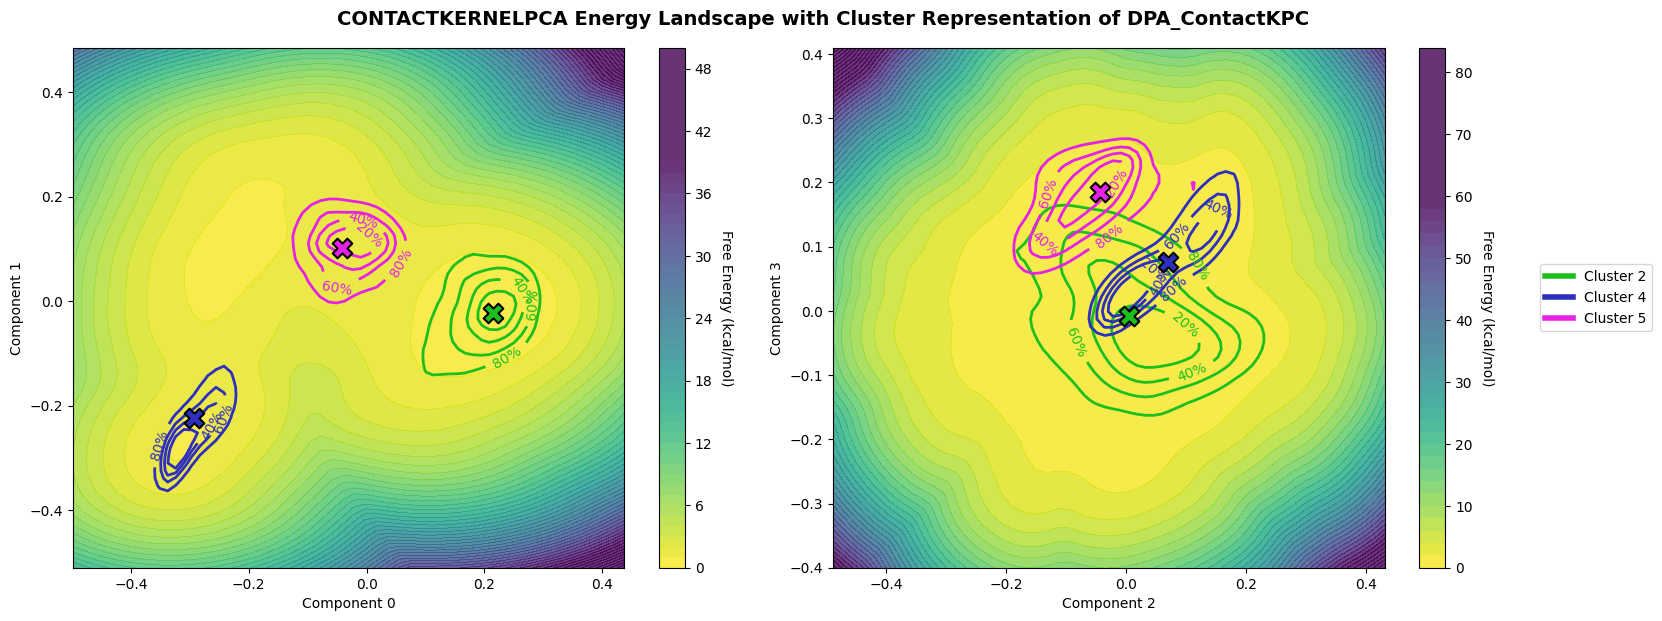

In [16]:
fig = pipeline.plots.landscape(
    decomposition_name="ContactKernelPCA",
    dimensions=[0, 1, 2, 3],
    energy_values=True,
    clustering_name="DPA_ContactKPC",
    show_centers=True,
    temperature=310.15,
    bins=50,
    cluster_contour=True,
    cluster_contour_voronoi=False,
    subplot_size=6,
    show_clusters=[2,4,5]
)

### Step 7: Comparative Analysis Setup

Having identified conformational states, we now address the key biological question: which molecular interactions define each state? 

Data selectors organize trajectory frames by cluster membership, enabling systematic comparison between states. 

The one-vs-rest strategy identifies features that distinguish each state from all others, revealing the defining characteristics rather than just pairwise differences. 

This approach provides a comprehensive molecular fingerprint for each conformational state.

In [8]:
# Create data selectors for each cluster
n_clusters = pipeline.data.cluster_data["DPA_ContactKPC"].get_n_clusters()
for i in range(n_clusters):
    pipeline.data_selector.create(f"cluster_{i}")
    pipeline.data_selector.select_by_cluster(f"cluster_{i}", "DPA_ContactKPC", [i])

# Create one-vs-all comparison
cluster_names = [f"cluster_{i}" for i in range(n_clusters)]
pipeline.comparison.create_comparison(
    name="cluster_comparison",
    mode="one_vs_rest",
    feature_selector="contacts_only",
    data_selectors=cluster_names
)

### **Step 8: Identifying Key Contacts with a Decision Tree**

So, after we set up our "one-vs-rest" comparisons in Step 6. We now have to ask the question of, how do we actually find the molecular interactions that define each state? For this, we will use decision trees.

A decision tree is a great choice for this task because it creates a flowchart or tree of simple "yes/no" questions to classify the data. This is ideal for our purposes, cause tt works perfectly with our binary contact data (a contact is either formed or not) and is easy to interpret. It generates a set of human-readable rules that explain what makes a state unique.

A crucial point is, that we are not trying to build a perfect model to predict the state of new, unseen data, but use it as an explanatory tool. 
Our goal is to have the model describe the data we already have as accurately as possible.

We want it to tell us which contacts are the most important for distinguishing the conformational states we've found. Therefore, the traditional concern about "overfitting" doesn't apply here, cause we are interested in the features that define our specific dataset.

To ensure the rules are simple and easy to understand, we limit the tree's complexity by setting `max_depth=3`. This forces the model to use only the most dominant and influential contacts to classify a state. 

In [9]:
# TODO: Reference

# Analyze feature importance
pipeline.feature_importance.add.decision_tree(
    comparison_name="cluster_comparison",
    analysis_name="feature_importance",
    max_depth=3,
)

Creating frame selection: 100%|██████████| 10/10 [00:00<00:00, 118.30chunks/s]


### **Step 9: Identifying the Top Contacts**

The decision tree analysis provides a feature importance score for every contact. `scikit-learn` calculates this value as the Gini Importance or the Entropy,  depending on which `criterion` was used to create the trees. Default is `gini`.
This score measures how effective a contact is at creating "purer" decision nodes in the tree. In other words, how well it helps to cleanly separate one state from all the others.

These scores are normalized to a range between 0.0 and 1.0. A higher score means more important feature in the fingerprint of this cluster.

To focus on the most essential information, we select the 3 contacts with the highest feature importance scores. These few contacts represent the core of the fingerprint for that state.

In [10]:
# TODO: Reference

# Get top features for each cluster vs rest
for i in range(min(3, n_clusters)):  # Show first 3 clusters
    sub_comparison_name = f"cluster_{i}_vs_rest"
    
    top_features = pipeline.feature_importance.get_top_features(
        analysis_name="feature_importance",
        comparison_identifier=sub_comparison_name,
        n=3
    )
    
    print(f"\nTop 3 features distinguishing Cluster {i}:")
    for j, feature_info in enumerate(top_features, 1):
        print(f"  {j}. {feature_info['feature_name']}: {feature_info['importance_score']:.3f}")


Top 3 features distinguishing Cluster 0:
  1. ALA26-PRO35: 0.318
  2. PRO17-SER43: 0.300
  3. LEU13-VAL33: 0.102

Top 3 features distinguishing Cluster 1:
  1. PRO35-LYS38: 0.584
  2. PRO17-SER43: 0.237
  3. ALA25-ASP28: 0.124

Top 3 features distinguishing Cluster 2:
  1. VAL20-THR24: 0.960
  2. ALA25-ASP28: 0.026
  3. THR24-ASP28: 0.010


### **Step 10: Saving and loading the pipeline**

In mdxplain you can save a whole pipeline with all your data and calculations and load it later again. Just do the following.

In [11]:
pipeline.save("cache/example_pipeline.pkl")

In [12]:
loaded_pipeline = PipelineManager()
loaded_pipeline.load("cache/example_pipeline.pkl")

### **Step 11: Info Printing**

With `print_info()` you can get a lot of informations about the content of your pipeline. After or before the loading. To know, whats in there.

In [13]:
loaded_pipeline.print_info()

======= PIPELINE INFORMATION =======

--- Trajectory Data ---
Loaded 1 trajectories:
  [0] 2RJY_protein_simulation_run1: 9368 frames

--- Feature Data ---
=== Feature Information ===
Feature Types: 2 (distances, contacts)

--- distances ---
Trajectory 0:
=== FeatureData ===
Feature Type: Distances
Original Data: 9368 frames x 1953 features
Feature Metadata: 1953 feature definitions

--- contacts ---
Trajectory 0:
=== FeatureData ===
Feature Type: Contacts
Original Data: 9368 frames x 1953 features
Feature Metadata: 1953 feature definitions

--- Feature Selection Data ---
=== FeatureSelectorData Information ===
FeatureSelectorData Names: 1 (contacts_only)

--- contacts_only ---
=== FeatureSelectorData ===
Name: contacts_only
Feature Types: 1 (contacts)
Total Selections: 1
Reference Trajectory: 0
Matrix Columns: 1953
Selection Results: Available for 1 feature types (contacts)

--- Clustering Data ---
=== ClusteringData Information ===
ClusteringData Names: 1 (DPA_ContactKPC)

--- DPA_Con

## Discussion

This tutorial walked through an end‑to‑end, contact‑focused workflow: Feature engineering of residue contacts, dimensionality reduction with Contact Kernel PCA, and clustering with DPA, to identify conformational states and the specific interactions that define them. 

The key strength of mdxplain is its modular pipeline builder: each step can be swapped or extended without changing the overall flow, and all intermediate results are collected and reused via `pipeline.data`.

Beyond the minimal example, mdxplain supports a broader feature set (e.g., DSSP/secondary structure, torsion angles, SASA, distances, raw coordinates) and multiple alternatives for dimensionality reduction and clustering. 

By standardizing data flow and bookkeeping, the library streamlines building and saving analyses. 

Common applications include:
- Exporting feature matrices for downstream machine‑learning models.
- Tag‑based comparisons across conditions (e.g., wild type vs mutant, ligand‑bound vs apo) to identify discriminative features (contacts, secondary structure, SASA) and explain structural/dynamical effects.
- Estimating state transition counts and preparing inputs for Markov state models.
- Computing contact frequencies or other statistical feature properties and their differences across systems.
- Doing RMSD and RMSF analysis for basic insights into the systems.
- Paralell working on many trajectories at once.
- Having many different metrices and features of many different trajectories at one place.

And many more.

To extend the workflow, `pipeline.analysis.structure` provides multiple RMSD/RMSF metrics, and `pipeline.analysis.feature.*` offers per‑feature statistics (e.g., contact frequencies, transition counts). Combining these with state discovery enables richer, multi‑faceted analyses that connect structure, dynamics, and feature statistics.

### Limitations and outlook

The quality of any analysis depends on adequate conformational sampling and the suitability of the chosen descriptors. Hyperparameters such as contact cutoffs, the number of components, and clustering sensitivity may require light tuning across systems.

Also there are thousands of different other methods one could use for the analysis. But for this cases, mdxplain serves you with the necessary feature-data in an memory efficient, performant and streamlined way. 

But with this, there is another limitation. Disk space. If you use your disk for big analysis, cause your trajectory and feature data does not fit in RAM, you need disk space. For hugh system this can also become a problem. 

## Conclusion

mdxplain lowers the effort to move from raw trajectories to interpretable, testable insights by simplifying the composition, execution, and persistence of complex structural analysis pipelines. Its modular design and extensibility make it a practical tool across structural biology use cases.

# References

[1] Crystal Structure of a pH-Stabilized Mutant of Villin Headpiece, Jianmin Meng and C. James McKnight, Biochemistry 2008 47 (16), 4644-4650, DOI: 10.1021/bi7022738

[2] ROCKLIN, Gabriel J., et al. Global analysis of protein folding using massively parallel design, synthesis, and testing. Science, 2017, 357. Jg., Nr. 6347, S. 168-175.

[3] Melvin RL, Godwin RC, Xiao J, Thompson WG, Berenhaut KS, Salsbury FR Jr. Uncovering Large-Scale Conformational Change in Molecular Dynamics without Prior Knowledge. J Chem Theory Comput. 2016 Dec 13;12(12):6130-6146. doi: 10.1021/acs.jctc.6b00757

[4] H. Lei,C. Wu,H. Liu, & Y. Duan,  Folding free-energy landscape of villin headpiece subdomain from molecular dynamics simulations, Proc. Natl. Acad. Sci. U.S.A. 104 (12) 4925-4930, https://doi.org/10.1073/pnas.0608432104 (2007).

[5] Ensign DL, Kasson PM, Pande VS. Heterogeneity even at the speed limit of folding: large-scale molecular dynamics study of a fast-folding variant of the villin headpiece. J Mol Biol. 2007 Nov 30;374(3):806-16. doi: 10.1016/j.jmb.2007.09.069. Epub 2007 Sep 29. Erratum in: J Mol Biol. 2008 Nov 21;383(4):935. PMID: 17950314; PMCID: PMC3689540.

[6] Roy González-Alemán, Daniel Platero-Rochart, David Hernández-Castillo, Erix W Hernández-Rodríguez, Julio Caballero, Fabrice Leclerc, Luis Montero-Cabrera, BitQT: a graph-based approach to the quality threshold clustering of molecular dynamics, Bioinformatics, Volume 38, Issue 1, January 2022, Pages 73–79, https://doi.org/10.1093/bioinformatics/btab595

[7] WANG, Ercheng, et al. A novel folding pathway of the villin headpiece subdomain HP35. Physical Chemistry Chemical Physics, 2019, 21. Jg., Nr. 33, S. 18219-18226.

# AI Disclaimer

This notebook was written with the suppport of Github Copilot with OpenAI GPT-5 and Google Gemini 2.5 Pro